In [35]:
import gensim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from scipy.sparse.csr import csr_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Let's us read the input data
df = pd.read_csv('/content/drive/MyDrive/TFM/data/export_expedientes_cleaned.csv', sep=',', encoding='UTF8')
df.head()

,id_capitulo,id_concepto,id_partida_generica,descripcion,clean_text
0,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN LA COO...,servicio profesional consistente coordinación ...
1,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar des...
2,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar man...
3,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...
4,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,servicio profesional consistente coadyuvar log...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617067 entries, 0 to 617066
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   id_capitulo          617067 non-null  int64 
 1   id_concepto          617067 non-null  int64 
 2   id_partida_generica  617067 non-null  int64 
 3   descripcion          617067 non-null  object
 4   clean_text           617067 non-null  object
dtypes: int64(3), object(2)
memory usage: 23.5+ MB


In [5]:
df.isnull().sum()

id_capitulo            0
id_concepto            0
id_partida_generica    0
descripcion            0
clean_text             0
dtype: int64

In [ ]:
df = df.sample(n=500000, random_state=1)
df

,id_capitulo,id_concepto,id_partida_generica,descripcion
246729,2000,2500,2530,Infliximab SOLUCIÓN INYECTABLE El frasco ámpul...
71686,3000,3200,3250,SERVICIO DE ARRENDAMIENTO INTEGRAL DE VEHÍCULO...
26815,6000,6100,6150,Invitación E350-2018 Seguimiento y control par...
294323,3000,3500,3510,TRABAJOS DE REHABILTACIÓN Y MANTTO. EN LA ESTA...
224244,2000,2500,2530,ADQUISICION DE INSUMOS DE LISOSOMALES (IDURSUL...
...,...,...,...,...
543834,2000,2500,2530,E297-2021 - ADQUISICION DE MEDICAMENTO Y ESTUP...
55834,5000,5300,5310,AA-050GYR017-E80-2018 ADQUISICIÓN DE EQUIPOS M...
451835,3000,3300,3360,SERVICIO DE IMPRESION DE TRIPTICOS INFORMATIVOS
582010,2000,2500,2540,SDI INVESTIGACIÓN DE MERCADO GPO 379


In [6]:
df.groupby(['id_capitulo']).count()['descripcion']

id_capitulo
2000    265502
3000    267618
5000     17068
6000     66879
Name: descripcion, dtype: int64

In [7]:
df.groupby(['id_concepto']).count()['descripcion']

id_concepto
2100     19225
2200     10327
2300    108601
2400      9815
2500     91712
2600      6284
2700      7244
2800       591
2900     11703
3100     12438
3200     12359
3300    153816
3400      5505
3500     63586
3600      7575
3700      3096
3800      2785
3900      6458
5100      4884
5200       913
5300      5345
5400      1563
5500       135
5600      3171
5700        62
5800       582
5900       413
6100     48033
6200     17413
6300      1433
Name: descripcion, dtype: int64

In [8]:
#Preprocessing for word2vect
def preprocessing(sentence):
  return gensim.utils.simple_preprocess(sentence, deacc=True, min_len=3, max_len=15)

In [9]:
#Preprocessing for word2vect
df['clean_text'] = df['clean_text'].apply(lambda description: preprocessing(description))
df

,id_capitulo,id_concepto,id_partida_generica,descripcion,clean_text
0,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN LA COO...,"[servicio, profesional, consistente, coordinac..."
1,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,"[servicio, profesional, consistente, coadyuvar..."
2,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,"[servicio, profesional, consistente, coadyuvar..."
3,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,"[servicio, profesional, consistente, coadyuvar..."
4,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,"[servicio, profesional, consistente, coadyuvar..."
...,...,...,...,...,...
617062,3000,3300,3390,PRESTAR SERVICIOS PROFESIONALES EN LA COORDINA...,"[prestar, servicio, profesional, coordinacion,..."
617063,3000,3300,3390,PRESTAR SERVICIOS PROFESIONALES EN LA COORDINA...,"[prestar, servicio, profesional, coordinacion,..."
617064,3000,3300,3390,PRESTAR SERVICIOS PROFESIONALES EN LA COORDINA...,"[prestar, servicio, profesional, coordinacion,..."
617065,3000,3300,3390,SERVICIOS PROFESIONALES CONSISTENTES EN COADYU...,"[servicio, profesional, consistente, coadyuvar..."


In [10]:
w2v_model=gensim.models.Word2Vec(df['clean_text'], size=100, window=5, min_count=2, sg=1, iter=15, seed=1852)
w2v_model.train(df['clean_text'], total_examples=w2v_model.corpus_count, epochs=w2v_model.iter)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  


(76578569, 83349930)

In [11]:
#we can extract the generated word embeddings 
w2v_embeddings=w2v_model.wv

In [12]:
#the vocabulary represented by the W2V model
w2v_vocabulary=w2v_embeddings.vocab.keys()

In [13]:
len(w2v_vocabulary)

40995

In [ ]:
w2v_vocabulary

dict_keys(['infliximab', 'solucion', 'inyectable', 'frasco', 'ampula', 'con', 'liofilizado', 'contiene', 'envase', 'instructivo', 'servicio', 'arrendamiento', 'integral', 'vehiculos', 'terrestres', 'para', 'financiera', 'nacional', 'desarrollo', 'agropecuario', 'rural', 'forestal', 'pesquero', 'invitacion', 'seguimiento', 'control', 'los', 'trabajos', 'relativos', 'reconstruccion', 'total', 'treinta', 'seis', 'caminos', 'acciones', 'municipio', 'candelaria', 'loxicha', 'accion', 'pluma', 'hidalgo', 'san', 'mateo', 'pinas', 'miguel', 'del', 'puerto', 'pedro', 'pochutla', 'santa', 'maria', 'colotepec', 'huatulco', 'tonameca', 'atender', 'danos', 'ocasionados', 'por', 'ocurrencia', 'lluvia', 'severa', 'mayo', 'junio', 'municipios', 'estado', 'oaxaca', 'rehabiltacion', 'mantto', 'estancia', 'bienestar', 'infantil', 'adquisicion', 'insumos', 'lisosomales', 'idursulfasa', 'elosulfasa', 'suministro', 'realizacion', 'spot', 'video', 'segundos', 'spots', 'television', 'radio', 'capsulas', 'dura

In [14]:
#Para vectorizar una sentencia se promedia cada el vectodr generado con el word2vec model para cada palabra
def vectorize_sentence(sentence,model):
    a = []
    for i in sentence:
        try:
            a.append(model.get_vector(str(i)))
        except:
            pass
        
    a=np.array(a).mean(axis=0)
    a = np.zeros(100) if np.all(a!=a) else a
    return a

In [16]:
word="software"
w2v_embeddings.most_similar(positive=word)

[('licenciamiento', 0.8786050081253052),
 ('transoft', 0.7937026023864746),
 ('multiphysics', 0.7870261073112488),
 ('webfocus', 0.7865945100784302),
 ('microfocus', 0.7821418642997742),
 ('licienciamiento', 0.7716525793075562),
 ('delmia', 0.7709503173828125),
 ('mathematica', 0.7659719586372375),
 ('eviews', 0.7655628323554993),
 ('toar', 0.764175534248352)]

In [17]:
#Vector for a word
w2v_embeddings.get_vector('solucion')

array([-0.0635872 ,  0.54484195, -0.5844263 ,  0.5561194 , -0.23175608,
        0.15171814,  0.4528764 , -0.2764009 , -0.46439204, -0.15939155,
       -0.9859671 ,  0.00292953, -0.6977672 ,  0.5449812 ,  0.35169223,
        0.37606993, -0.1620379 ,  0.50655127, -0.03150698, -0.3809929 ,
        0.1927273 , -0.372333  ,  1.1453706 ,  0.4018755 ,  0.0900243 ,
        0.5909685 ,  0.0096506 ,  0.6803677 ,  0.75168914, -0.37466097,
        0.28198802, -0.11760733, -0.2976967 ,  0.31632155, -0.39959693,
        0.6486672 ,  0.32469872, -0.44219637, -0.72585887,  0.92953604,
        0.3698482 ,  0.40389207,  0.922773  , -0.23348527,  0.0046636 ,
        0.7245517 ,  0.6047671 ,  0.2233209 , -0.6343353 ,  0.28208375,
        0.28531364,  0.5821102 ,  0.22813821,  0.4927149 , -0.09041603,
        0.21819833,  0.96686345,  0.45067644, -0.12293693,  0.8509244 ,
       -0.23962528, -0.19919415,  0.32587048, -0.61916584, -0.16888204,
       -0.4882486 , -0.42380914,  0.5813689 , -0.47555673, -0.31

In [20]:
print(len(w2v_embeddings.get_vector('servicio')))

100


In [19]:
vectorize_sentence(df['clean_text'].values[0], w2v_embeddings)

array([-0.02001268,  0.20889436,  0.4665793 ,  0.1287514 ,  0.01449467,
        0.00379049,  0.36979675, -0.00319373,  0.08082625, -0.40625325,
       -0.47020432, -0.00174887, -0.3623406 ,  0.20793739, -0.19983146,
       -0.04076807,  0.1482319 ,  0.11919318, -0.0097759 , -0.24597268,
       -0.13551167, -0.25924265,  0.21194473,  0.27248132, -0.08326527,
       -0.10874824,  0.4813787 ,  0.10146123,  0.29412514,  0.00340788,
        0.19656561,  0.24659383, -0.29579616, -0.09757636,  0.01084939,
        0.14546183,  0.28530645, -0.05953162,  0.00250059,  0.01226104,
        0.05349494,  0.17610687,  0.0606613 ,  0.16788906, -0.16926515,
        0.4066124 ,  0.2580051 ,  0.2802952 , -0.05560396,  0.09560469,
        0.14958863,  0.02697148, -0.2672267 , -0.24648781,  0.09350339,
        0.2567006 ,  0.3517952 , -0.11685425, -0.23748706,  0.00890785,
       -0.01665613,  0.1540347 , -0.21953179, -0.04862479, -0.15639625,
        0.11298135, -0.24791811,  0.15109292, -0.12474945,  0.31

In [21]:
# Everything looks ok. Now let's do the train-split as we did before.
X = df['clean_text'] # Text
Y = df['id_concepto'] # Labels

In [22]:
# Para solo mantener el valor númerico sin ceros 
Y = Y.apply(lambda division: str(int(division/100.0)))

In [24]:
X = X.apply(lambda description: vectorize_sentence(description, w2v_embeddings))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice.
  # Remove the CWD from sys.path while we load stuff.


In [25]:
#to sparse matrix
X_vect = csr_matrix(pd.DataFrame(np.vstack(X)))

In [26]:
X_vect

<617067x100 sparse matrix of type '<class 'numpy.float64'>'
	with 61675400 stored elements in Compressed Sparse Row format>

In [31]:
# Training = 80%, test = 20%
X_train, X_test, y_train, y_test = train_test_split(X_vect, Y, test_size=0.2, stratify=Y, shuffle = True, random_state=0)

In [32]:
X_train

<493653x100 sparse matrix of type '<class 'numpy.float64'>'
	with 49340700 stored elements in Compressed Sparse Row format>

In [27]:
def multi_label_metrics(y_true,y_pred):
    # compute metrics
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
   
    # return as dictionary
    metrics = {'balanced_accuracy_score': balanced_accuracy,
               'accuracy': accuracy}
    return metrics

In [28]:
def describe_performance(gridSearchCVModel, y_test, y_pred):
  print("Best parameters set found on training set:")
  print()
  print("best parameters: ",gridSearchCVModel.best_params_)
  print()
  print("Grid scores on testing set:")
  print()
  means_score = gridSearchCVModel.cv_results_["mean_test_score"]
  stds_scroe = gridSearchCVModel.cv_results_["std_test_score"]
  for mean, std, params in zip(means_score, stds_scroe, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
  print()
  print("best score: ", gridSearchCVModel.best_score_)
  print()
  print("Grid times on testing set:")
  print()
  means_fit_time = gridSearchCVModel.cv_results_["mean_fit_time"]
  std_fit_time = gridSearchCVModel.cv_results_["std_fit_time"]
  for mean, std, params in zip(means_fit_time, std_fit_time, gridSearchCVModel.cv_results_["params"]):
      print("%0.3f seconds (+/-%0.03f) for %r" % (mean, std * 2, params))
  print("Detailed classification report:")
  print()
  print("The model is trained on the full training set.")
  print("The scores are computed on the full testing set.")
  print()
  print(multi_label_metrics(y_test, y_pred))
  print(metrics.classification_report(y_test, y_pred))
  print()

In [29]:
def plot_confusion_matrix(y_test, y_pred):
  #Confusion matrix test
  plt.clf()
  fig,ax = plt.subplots(figsize=(22,22))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
  plt.show() 

##Scaler

In [33]:
from sklearn.preprocessing import StandardScaler 
#removes the mean and scales the data to unit variance. [-0.2, 0.2] range
scaler = StandardScaler(with_mean=False).fit(X_vect)
X_train_SS = scaler.transform(X_train)
X_test_SS = scaler.transform(X_test)

##MultinomialNB

In [37]:
from sklearn.naive_bayes import GaussianNB
parametersMNB = { 
                 'var_smoothing':[1e-9]
                }
modelMNB = GaussianNB()

In [38]:
clf_MNB_GS = GridSearchCV(modelMNB, parametersMNB, cv=3, n_jobs=-1, verbose=3)
clf_MNB_GS.fit(X_train_SS.toarray(), y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


GridSearchCV(cv=3, estimator=GaussianNB(), n_jobs=-1,
             param_grid={'var_smoothing': [1e-09]}, verbose=3)

In [39]:
# Let's see the results
y_pred = clf_MNB_GS.predict(X_test_SS.toarray())
#Model performance
describe_performance(clf_MNB_GS, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'var_smoothing': 1e-09}

Grid scores on testing set:

0.678 (+/-0.001) for {'var_smoothing': 1e-09}

best score:  0.6777452988232625

Grid times on testing set:

3.804 seconds (+/-0.978) for {'var_smoothing': 1e-09}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.5713500863538343, 'accuracy': 0.6774758131168263}
              precision    recall  f1-score   support

          21       0.55      0.61      0.58      3845
          22       0.64      0.62      0.63      2065
          23       0.89      0.93      0.91     21720
          24       0.42      0.50      0.45      1963
          25       0.92      0.68      0.78     18342
          26       0.69      0.79      0.74      1257
          27       0.74      0.62      0.68      1449
          28       0.18      0.36      0.24       118
          29       0.51 

<Figure size 432x288 with 0 Axes>

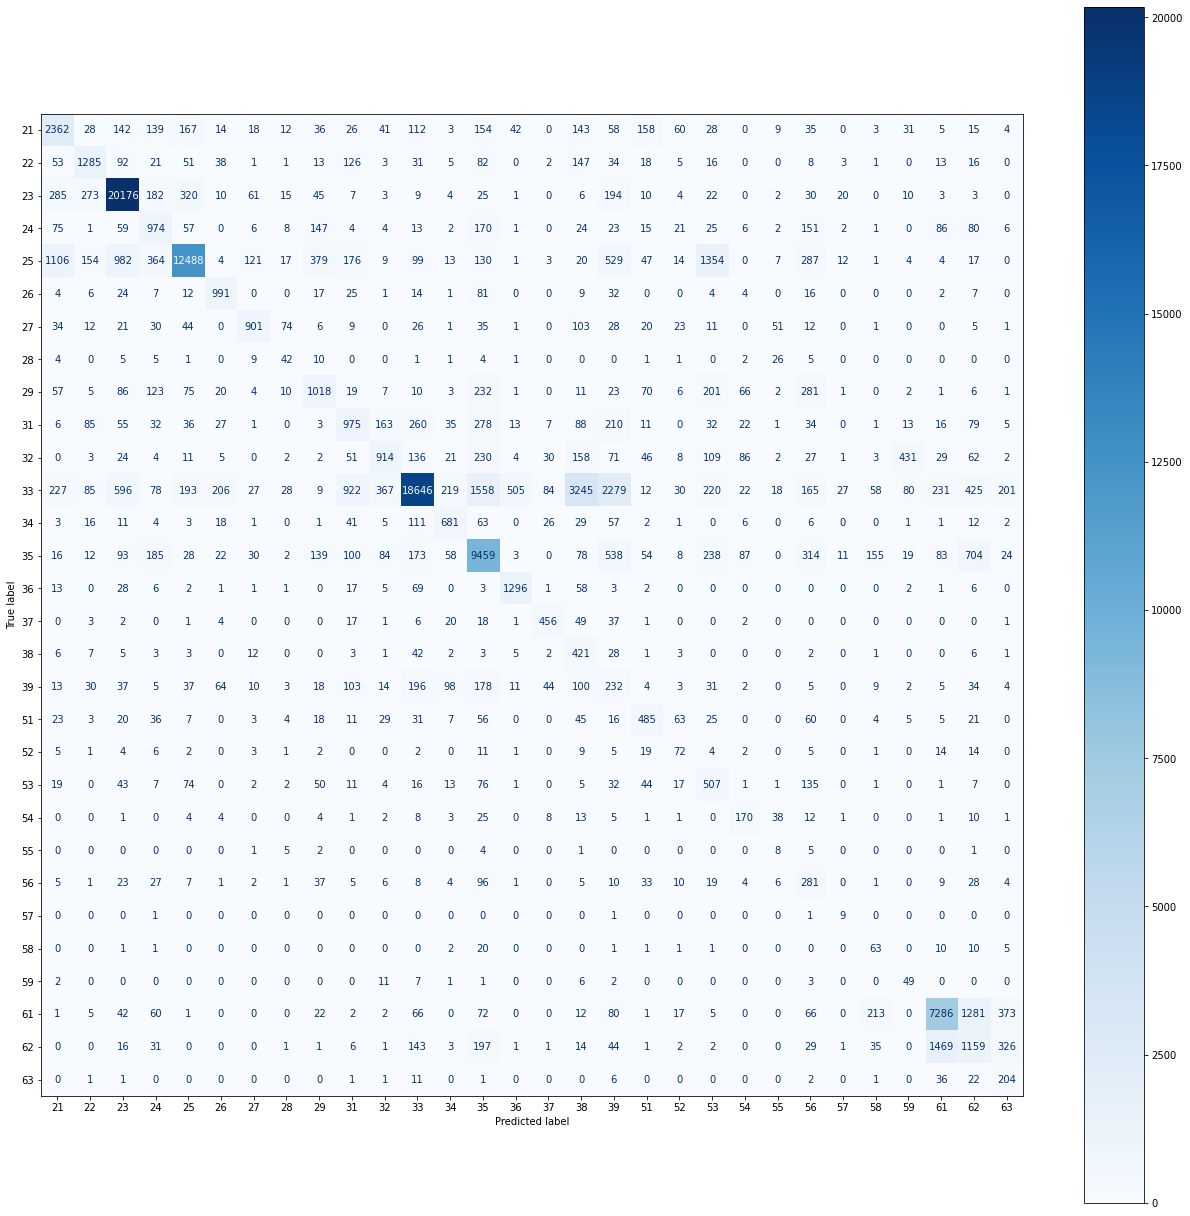

In [40]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##LinearSVM

In [41]:
#For large datasets consider using LinearSVC = SGDClassifier with loss hinge and penalty l2
parametersSVM = { 
                 'max_iter':[100, 200, 500, 700]
                 }
modelSVM = SGDClassifier(loss='hinge', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [42]:
#Model and hyperparameters
clf_GS_SVM = GridSearchCV(modelSVM, parametersSVM, cv=2, n_jobs=-1, verbose=10)
clf_GS_SVM.fit(X_train_SS, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 5.82, NNZs: 100, Bias: -0.047606, T: 444287, Avg. loss: 0.226493
Total training time: 0.61 seconds.
Norm: 3.39, NNZs: 100, Bias: -0.359910, T: 444287, Avg. loss: 0.281156
Total training time: 0.57 seconds.
-- Epoch 2
-- Epoch 2
Norm: 3.49, NNZs: 100, Bias: -0.065996, T: 888574, Avg. loss: 0.044662
Total training time: 1.52 seconds.
Norm: 2.35, NNZs: 100, Bias: -0.391057, T: 888574, Avg. loss: 0.072019
Total training time: 1.47 seconds.
-- Epoch 3
-- Epoch 3
Norm: 3.06, NNZs: 100, Bias: -0.076151, T: 1332861, Avg. loss: 0.035686
Total training time: 2.41 seconds.
Norm: 1.93, NNZs: 100, Bias: -0.411046, T: 1332861, Avg. loss: 0.061161
Total training time: 2.36 seconds.
-- Epoch 4
-- Epoch 4
Norm: 2.69, NNZs: 100, Bias: -0.083625, T: 1777148, Avg. loss: 0.032491
Total training time: 3.28 seconds.
Norm: 1.79, NNZs: 100, Bias: -0.426794, T: 1777148, Avg. loss: 0.056557
Total training time: 3.24 seconds.
-- Epoch 5
-- Epoch 5
Norm: 2.57, NNZs: 100, Bias: -0.089560

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.4min finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, n_jobs=-1,
                                     random_state=42, verbose=2),
             n_jobs=-1, param_grid={'max_iter': [100, 200, 500, 700]},
             verbose=10)

In [43]:
# Let's see the results
y_pred = clf_GS_SVM.predict(X_test_SS)
#Models performance
describe_performance(clf_GS_SVM, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'max_iter': 100}

Grid scores on testing set:

0.715 (+/-0.015) for {'max_iter': 100}
0.715 (+/-0.015) for {'max_iter': 200}
0.715 (+/-0.015) for {'max_iter': 500}
0.715 (+/-0.015) for {'max_iter': 700}

best score:  0.7150022235010756

Grid times on testing set:

92.094 seconds (+/-0.801) for {'max_iter': 100}
77.013 seconds (+/-0.119) for {'max_iter': 200}
77.741 seconds (+/-0.509) for {'max_iter': 500}
77.727 seconds (+/-1.475) for {'max_iter': 700}
Detailed classification report:

The model is trained on the full training set.
The scores are computed on the full testing set.

{'balanced_accuracy_score': 0.5822849703140798, 'accuracy': 0.7109728231805144}
              precision    recall  f1-score   support

          21       0.65      0.69      0.67      3845
          22       0.73      0.70      0.72      2065
          23       0.97      0.94      0.96     21720
          24       0.42      0.49      0.45      1963

In [ ]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##SGDClassifier

In [45]:
#Model and hyperparameters
parametersSGD = { 
                 'max_iter':[100, 200, 300, 500],
                 'loss':['modified_huber', 'squared_hinge', 'perceptron']
                 }
modelSGD = SGDClassifier(loss='perceptron', 
                         penalty='l2',
                         max_iter=1000, 
                         n_jobs=-1,
                         class_weight='balanced', 
                         early_stopping=True,
                         random_state=42, 
                         verbose=2)

In [46]:
#Model and hyperparameters
clf_GS_SGD = GridSearchCV(modelSGD, parametersSGD, cv=2, n_jobs=-1, verbose=10)
clf_GS_SGD.fit(X_train_SS, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


-- Epoch 1
-- Epoch 1
Norm: 16.43, NNZs: 100, Bias: 0.185181, T: 444287, Avg. loss: 3.117024
Total training time: 0.57 seconds.
Norm: 8.75, NNZs: 100, Bias: -0.555562, T: 444287, Avg. loss: 3.934743
Total training time: 0.58 seconds.
-- Epoch 2
-- Epoch 2
Norm: 7.39, NNZs: 100, Bias: 0.176321, T: 888574, Avg. loss: 0.338937
Total training time: 1.52 seconds.
Norm: 3.77, NNZs: 100, Bias: -0.540495, T: 888574, Avg. loss: 0.415529
Total training time: 1.54 seconds.
-- Epoch 3
-- Epoch 3
Norm: 5.24, NNZs: 100, Bias: 0.174741, T: 1332861, Avg. loss: 0.193139
Total training time: 2.44 seconds.
Norm: 2.61, NNZs: 100, Bias: -0.532541, T: 1332861, Avg. loss: 0.238754
Total training time: 2.43 seconds.
-- Epoch 4
-- Epoch 4
Norm: 3.71, NNZs: 100, Bias: 0.169717, T: 1777148, Avg. loss: 0.137354
Total training time: 3.37 seconds.
Norm: 2.02, NNZs: 100, Bias: -0.527460, T: 1777148, Avg. loss: 0.171807
Total training time: 3.37 seconds.
-- Epoch 5
-- Epoch 5
Norm: 3.05, NNZs: 100, Bias: 0.164629, T:

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.5min finished


GridSearchCV(cv=2,
             estimator=SGDClassifier(class_weight='balanced',
                                     early_stopping=True, loss='perceptron',
                                     n_jobs=-1, random_state=42, verbose=2),
             n_jobs=-1,
             param_grid={'loss': ['modified_huber', 'squared_hinge',
                                  'perceptron'],
                         'max_iter': [100, 200, 300, 500]},
             verbose=10)

In [47]:
# Let's see the results
y_pred = clf_GS_SGD.predict(X_test_SS)
#Model performance
describe_performance(clf_GS_SGD, y_test, y_pred)

Best parameters set found on training set:

best parameters:  {'loss': 'modified_huber', 'max_iter': 100}

Grid scores on testing set:

0.673 (+/-0.052) for {'loss': 'modified_huber', 'max_iter': 100}
0.673 (+/-0.052) for {'loss': 'modified_huber', 'max_iter': 200}
0.673 (+/-0.052) for {'loss': 'modified_huber', 'max_iter': 300}
0.673 (+/-0.052) for {'loss': 'modified_huber', 'max_iter': 500}
0.542 (+/-0.029) for {'loss': 'squared_hinge', 'max_iter': 100}
0.542 (+/-0.029) for {'loss': 'squared_hinge', 'max_iter': 200}
0.542 (+/-0.029) for {'loss': 'squared_hinge', 'max_iter': 300}
0.542 (+/-0.029) for {'loss': 'squared_hinge', 'max_iter': 500}
0.611 (+/-0.055) for {'loss': 'perceptron', 'max_iter': 100}
0.611 (+/-0.055) for {'loss': 'perceptron', 'max_iter': 200}
0.611 (+/-0.055) for {'loss': 'perceptron', 'max_iter': 300}
0.611 (+/-0.055) for {'loss': 'perceptron', 'max_iter': 500}

best score:  0.6731550822358844

Grid times on testing set:

78.534 seconds (+/-1.470) for {'loss': 'mo

<Figure size 432x288 with 0 Axes>

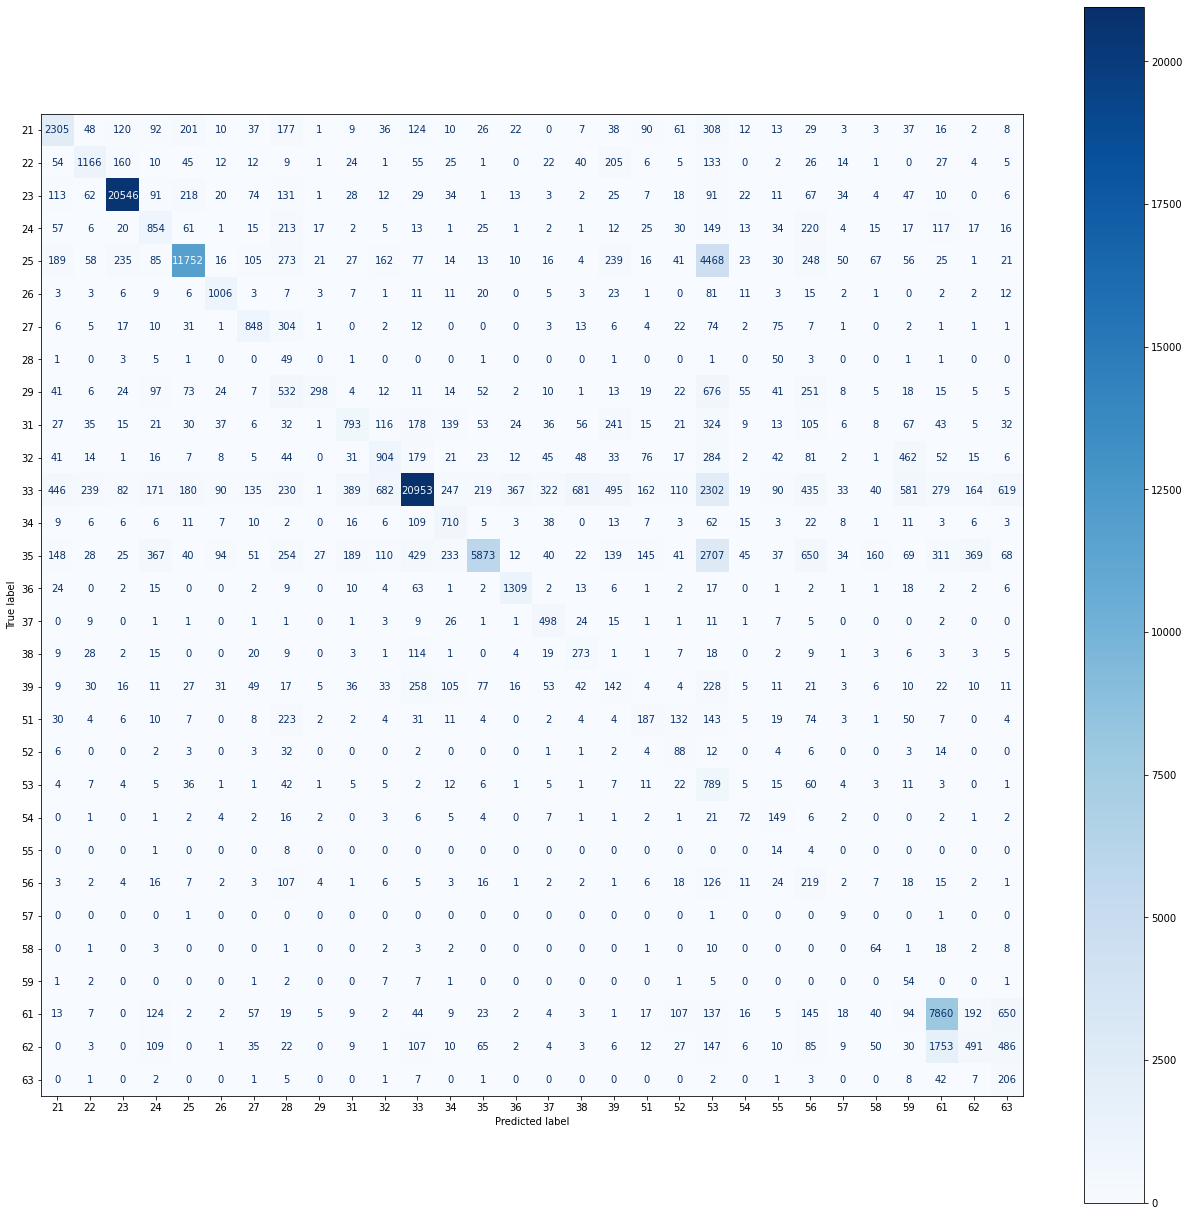

In [48]:
#Confusion Matrix 
plot_confusion_matrix(y_test, y_pred)

##Otras pruebas

In [ ]:
# Classify algoritmo SVM
SVM = SVC(C=1.0, kernel='linear', degree=3, random_state=0, probability=True)
# Entrenamiento del algoritmo 
SVM.fit(X_train_w2v, y_train)

In [ ]:
# Let's see the results
y_pred = SVM.predict(X_test_w2v)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

Modelo más rapido LINEARSVC

In [ ]:
#For large datasets consider using LinearSVC
model = LinearSVC(C=1.0, penalty='l2', class_weight='balanced', random_state=42, max_iter=1000, verbose=1)

In [ ]:
# Entrenamiento del algoritmo 
model.fit(X_train_w2v, y_train)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(class_weight='balanced', random_state=42, verbose=1)

In [ ]:
# Let's see the results
y_pred = model.predict(X_test_w2v)

In [ ]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2000       0.95      0.92      0.93     43403
        3000       0.93      0.92      0.93     43041
        5000       0.44      0.62      0.51      2819
        6000       0.87      0.94      0.90     10737

    accuracy                           0.91    100000
   macro avg       0.80      0.85      0.82    100000
weighted avg       0.92      0.91      0.92    100000



<Figure size 432x288 with 0 Axes>

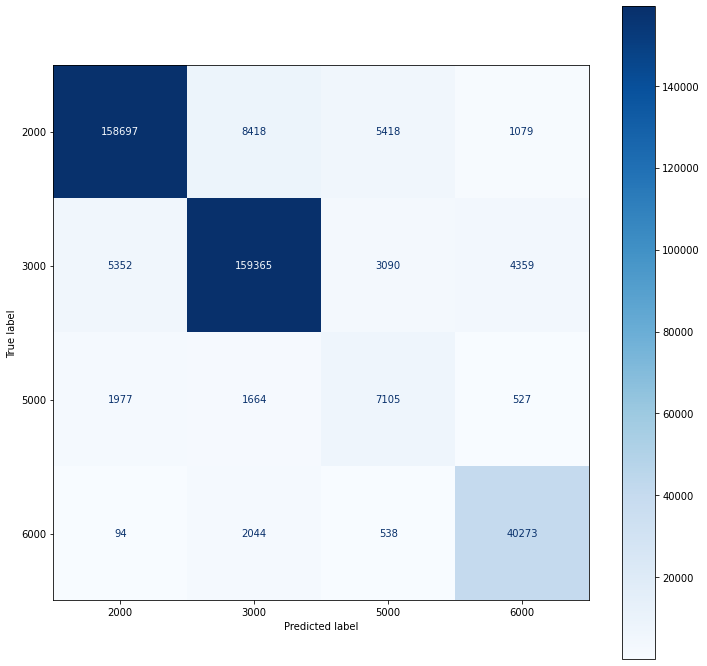

In [ ]:
#Confusion matrix train
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_estimator(model, X_train_w2v, y_train, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

<Figure size 432x288 with 0 Axes>

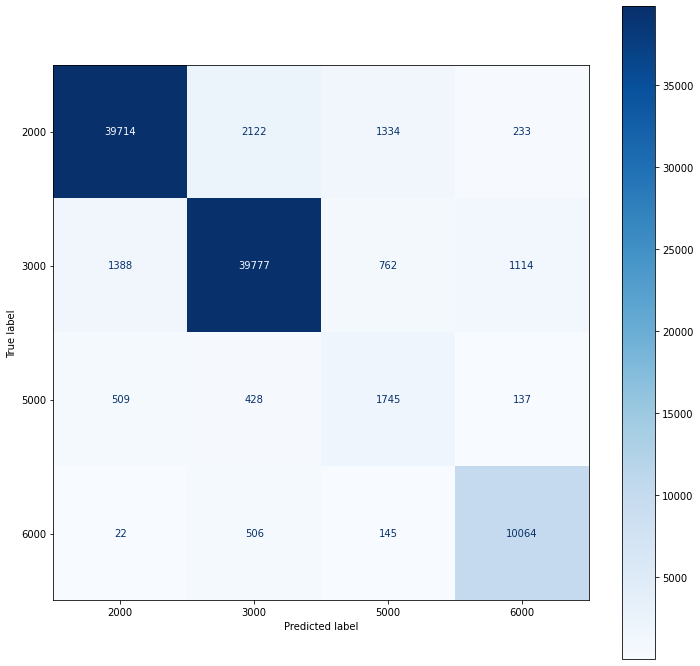

In [ ]:
#Confusion matrix test
plt.clf()
fig,ax = plt.subplots(figsize=(12,12))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap=plt.cm.Blues,  ax=ax, values_format='d')
plt.show() 

In [ ]:
# Finally, let's try the examples
examples = ["Semillas para la siembra",
                   "Alquiler en bar del paramo",
                   "Obras de metro y remodelación", 
                   "Materiales de papelería y oficina", 
                   "Grúas para demolición",
                   "Gruas para demolicion"]
examples = [preprocessing(example) for example in examples]
examples

[['semillas', 'para', 'siembra'],
 ['alquiler', 'bar', 'del', 'paramo'],
 ['obras', 'metro', 'remodelacion'],
 ['materiales', 'papeleria', 'oficina'],
 ['gruas', 'para', 'demolicion'],
 ['gruas', 'para', 'demolicion']]

In [ ]:
examples = [vectorize_sentence(example, w2v_embeddings) for example in examples]

In [ ]:
examples = scaler.transform(examples)

In [ ]:
#Prediction
test = model.predict(examples)
test

array([2000, 5000, 6000, 2000, 3000, 3000])

**Modelo para concepto**

In [ ]:
df.groupby(['id_concepto']).count()

,id_capitulo,id_partida_generica,descripcion,clean_text
id_concepto,,,,
2100,807,807,807,807
2200,399,399,399,399
2300,4454,4454,4454,4454
2400,385,385,385,385
2500,3809,3809,3809,3809
2600,250,250,250,250
2700,298,298,298,298
2800,24,24,24,24
2900,443,443,443,443
